# Getting Started with Aegirio

This example is based on the KubeFlow [Financial Time Series with Finance Data](https://github.com/kubeflow/examples/blob/master/financial_time_series/Financial%20Time%20Series%20with%20Finance%20Data.ipynb) example

This solution presents an example of machine learning workflow using financial time series data.

In this solution, you will:

1. Get data for financial markets using:
    * an SQL query
    * a REST API call
    * an uploaded CSV file
2. Preprocess the data
    * Load into a Pandas Data Frame in a usable format
    * Normalize the data
3.  Develope a model
    * Perform exploratory data analysis
    * Test on subset of full data
4. Train Model at Scale
    * Use TensorFlow to build, train and evaluate a number of models



## Thesis
Can we use information from a stock marketin an earlier time zone to gain an advantage for trading in a later time zone.

We will analyze closing prices from these 8 stock indices from Jan 1st, 2010 thru Oct 1, 2015


|Index|Country|Closing Time (EST)|Hours Before S&P Close|
|---|---|---|---|
|[All Ords](https://en.wikipedia.org/wiki/All_Ordinaries)|Australia|0100|15|
|[Nikkei 225](https://en.wikipedia.org/wiki/Nikkei_225)|Japan|0200|14|
|[Hang Seng](https://en.wikipedia.org/wiki/Hang_Seng_Index)|Hong Kong|0400|12|
|[DAX](https://en.wikipedia.org/wiki/DAX)|Germany|1130|4.5|
|[FTSE 100](https://en.wikipedia.org/wiki/FTSE_100_Index)|UK|1130|4.5|
|[NYSE Composite](https://en.wikipedia.org/wiki/NYSE_Composite)|US|1600|0|
|[Dow Jones Industrial Average](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average)|US|1600|0|
|[S&P 500](https://en.wikipedia.org/wiki/S%26P_500_Index)|US|1600|0|

## 1 - Get the Data
We will be using Pandas data frames to manipulate the data so we import the libraries we will need

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.plotting import scatter_matrix

### SQL Query

We will get several sets of data from a publicly available BigQuery database

In [2]:
from google.cloud import bigquery

# Instantiates a client
bigquery_client = bigquery.Client()

These strings are the last part part of the identifier in the BigQuery database. For example `bingo-ml-1.market_data.nyse`

In [3]:
tickers = ['snp', 'nyse', 'nikkei', 'hangseng', 'ftse', 'dax']

Get raw data

In [4]:
bq_query = {}
for ticker in tickers:
    bq_query[ticker] = bigquery_client.query('SELECT Date, Close from `bingo-ml-1.market_data.{}`'.format(ticker))

Next we pull the raw data to a temporary `results` object in a Pandas data frame format with the `Date` column as the index

In [5]:
results = {}
for ticker in tickers:
    results[ticker] = bq_query[ticker].result().to_dataframe().set_index('Date')

We now create our working DataFrame `closing_data` and move just the `Close` column into it

In [6]:
closing_data = pd.DataFrame()

for ticker in tickers:
    closing_data['{}_close'.format(ticker)] = results[ticker]['Close']

We use the pandas DataFrame `info()` method to see a summary of the data so far

In [7]:
closing_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1447 entries, 2015-05-12 to 2012-01-26
Data columns (total 6 columns):
snp_close         1447 non-null float64
nyse_close        1447 non-null float64
nikkei_close      1378 non-null float64
hangseng_close    1405 non-null float64
ftse_close        1440 non-null float64
dax_close         1434 non-null float64
dtypes: float64(6)
memory usage: 79.1 KB


We now have 6 of the 8 indices we want to analyze pulled in our Data Frame using a SQL query


### REST API Call
We will next get the Australian All Ordinaries closing price information from the [Yahoo Finance](https://finance.yahoo.com/quote/%5EAORD/history/) web service

We will need to convert the beginning and end dates of our series to a unix epoch before making the call to the web service

In [8]:
import time

start_date_time = '01/01/2010'
end_date_time = '10/1/2015'
pattern = '%m/%d/%Y'
start_epoch = int(time.mktime(time.strptime(start_date_time, pattern)))
end_epoch = int(time.mktime(time.strptime(end_date_time, pattern)))

start_epoch, end_epoch

(1262304000, 1443657600)

We displayed the values just to be sure they look about right

Next we will use these values to create a correctly formatted URL

In [9]:
import urllib.request

query_string = 'https://query1.finance.yahoo.com\
/v7/finance/download/%5EAORD?period1={0}&period2={1}&interval=1d&events=history'.format(start_epoch, end_epoch)

response = urllib.request.urlopen(query_string)

Pandas has many options available for reading CSV files into pandas DataFrames. The line below uses three options:
* `usecols` takes an array of column names to be includes in the DataFrame
* `index_col` takes an integer of the column to be used as the DataFrame index
* `date_parser` lets you include a lambda function to use for parsing one or more columns into a pandas Date format

In [10]:
results['yahooao'] = pd.read_csv(response, \
                                 usecols=['Date', 'Close'],\
                                 index_col=0, \
                                 date_parser=lambda col: pd.to_datetime(col, utc=True))

In [11]:
results['yahooao'].head()

,Close
Date,
2010-01-04 00:00:00+00:00,4889.799805
2010-01-05 00:00:00+00:00,4939.500000
2010-01-06 00:00:00+00:00,4946.799805
2010-01-07 00:00:00+00:00,4930.500000
2010-01-08 00:00:00+00:00,4942.200195


We use the pandas `head()` to look at the first few rows to be sure they look correct before moving the results into our working DataFrame and adding the name to our `tickers` list

In [12]:
closing_data['yahooao_close'] = results['yahooao']
tickers.append('yahooao')

In [13]:
closing_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1447 entries, 2015-05-12 to 2012-01-26
Data columns (total 7 columns):
snp_close         1447 non-null float64
nyse_close        1447 non-null float64
nikkei_close      1378 non-null float64
hangseng_close    1405 non-null float64
ftse_close        1440 non-null float64
dax_close         1434 non-null float64
yahooao_close     1412 non-null float64
dtypes: float64(7)
memory usage: 90.4 KB


The `info()` method now shows the All Ordinaries closing prices we pulled from Yahoo 

### Import CSV file

We will use the same options with pandas `read_csv()` method to import a CSV file. Instead of reading an HTTP response, we will read from a local file `DJIAHistoricalPrices.csv`

In [14]:
results['djia-csv'] = pd.read_csv('~/DJIAHistoricalPrices.csv', \
                                 usecols=['Date', 'Close'],\
                                 index_col=0, \
                                 date_parser=lambda col: pd.to_datetime(col, utc=True))

ValueError: Usecols do not match columns, columns expected but not found: ['Close']

You should see an error `ValueError: Usecols do not match columns, columns expected but not found: ['Close']`


Lets read the file in without any parsing and output the columns

In [15]:
pd.read_csv('~/DJIAHistoricalPrices.csv').columns

Index(['Date', ' Open', ' High', ' Low', ' Close'], dtype='object')

Now we see the problem, the 'CLose' column has a leading space

Adding a space in the `usecols` parameter array should fix the problem

In [16]:
results['djia-csv_close'] = pd.read_csv('~/DJIAHistoricalPrices.csv', \
                                 usecols=['Date', ' Close'],\
                                 index_col=0, \
                                 date_parser=lambda col: pd.to_datetime(col, utc=True))

In [17]:
results['djia-csv_close']


,Close
Date,
2015-10-01 00:00:00+00:00,16272.01
2015-09-30 00:00:00+00:00,16284.70
2015-09-29 00:00:00+00:00,16049.13
2015-09-28 00:00:00+00:00,16001.89
2015-09-25 00:00:00+00:00,16314.67
2015-09-24 00:00:00+00:00,16201.32
2015-09-23 00:00:00+00:00,16279.89
2015-09-22 00:00:00+00:00,16330.47
2015-09-21 00:00:00+00:00,16510.19


In [18]:
closing_data['djia-csv_close'] = results['djia-csv_close']
tickers.append('djia-csv')

In [19]:
closing_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1447 entries, 2015-05-12 to 2012-01-26
Data columns (total 8 columns):
snp_close         1447 non-null float64
nyse_close        1447 non-null float64
nikkei_close      1378 non-null float64
hangseng_close    1405 non-null float64
ftse_close        1440 non-null float64
dax_close         1434 non-null float64
yahooao_close     1412 non-null float64
djia-csv_close    1447 non-null float64
dtypes: float64(8)
memory usage: 101.7 KB


We now have our 8 sets of data in a pandas DataFrame, but we can see that due differing national holidays, there are different numbers of data points in each set 

In [20]:
closing_data.head()

,snp_close,nyse_close,nikkei_close,hangseng_close,ftse_close,dax_close,yahooao_close,djia-csv_close
Date,,,,,,,,
2015-05-12 00:00:00+00:00,2099.120117,11113.169922,19624.839844,27407.179688,6933.799805,11472.410156,5673.100098,18068.23
2012-11-02 00:00:00+00:00,1414.199951,8234.910156,9051.219727,22111.330078,5868.600098,7363.850098,4483.299805,13093.16
2014-03-28 00:00:00+00:00,1857.619995,10434.870117,14696.030273,22065.529297,6615.600098,9587.190430,5376.799805,16323.06
2010-09-30 00:00:00+00:00,1141.199951,7281.069824,9369.349609,22358.169922,5548.600098,6229.020020,4636.899902,10788.05
2015-04-22 00:00:00+00:00,2107.959961,11144.450195,20133.900391,27933.849609,7028.200195,11867.370117,5812.799805,18038.27


## 2 - Preprocess Data

In this section we will get the data ready by:
* Sorting the closing price values by date and fill in any gaps by repeating the previous days closing price
* Normalize the indicies to have values ranging between 0 and 1

### Sort and Fill missing valures

In [22]:
# Pandas includes a very convenient function for filling gaps in the data.
closing_data.sort_index(inplace=True)
closing_data = closing_data.fillna(method='ffill')

In [23]:
closing_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1447 entries, 2010-01-04 to 2015-10-01
Data columns (total 8 columns):
snp_close         1447 non-null float64
nyse_close        1447 non-null float64
nikkei_close      1447 non-null float64
hangseng_close    1447 non-null float64
ftse_close        1447 non-null float64
dax_close         1447 non-null float64
yahooao_close     1447 non-null float64
djia-csv_close    1447 non-null float64
dtypes: float64(8)
memory usage: 101.7 KB


In [24]:
closing_data.describe()


,snp_close,nyse_close,nikkei_close,hangseng_close,ftse_close,dax_close,yahooao_close,djia-csv_close
count,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000
mean,1549.733275,8920.468489,12529.915089,22245.750485,6100.506356,7965.888030,4913.879403,14017.461652
std,338.278280,1420.830375,3646.022665,2026.412936,553.389736,1759.572713,484.911779,2522.948807
min,1022.580017,6434.810059,8160.009766,16250.269531,4805.799805,5072.330078,3927.600098,9686.480000
25%,1271.239990,7668.234863,9465.930176,20841.259765,5677.899902,6457.090088,4500.250000,11987.635000
50%,1433.189941,8445.769531,10774.150391,22437.439453,6008.899902,7435.209961,4901.100098,13323.360000
75%,1875.510010,10370.324707,15163.069824,23425.334961,6622.650147,9409.709961,5346.650147,16413.575000
max,2130.820068,11239.660156,20868.029297,28442.750000,7104.000000,12374.730469,5954.799805,18312.390000


At this point we have:
* Sourced five years of financial index time series from a SQL database
* Pulled time series data for specific dates from a Web service
* Imported a CSV file with a mis-named column
* Combined the pertinent data into a single data structure, and harmonized the data to have the same number of entries

### Normalize Data

First, take a look at the data.

In [25]:
closing_data.describe()

,snp_close,nyse_close,nikkei_close,hangseng_close,ftse_close,dax_close,yahooao_close,djia-csv_close
count,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000
mean,1549.733275,8920.468489,12529.915089,22245.750485,6100.506356,7965.888030,4913.879403,14017.461652
std,338.278280,1420.830375,3646.022665,2026.412936,553.389736,1759.572713,484.911779,2522.948807
min,1022.580017,6434.810059,8160.009766,16250.269531,4805.799805,5072.330078,3927.600098,9686.480000
25%,1271.239990,7668.234863,9465.930176,20841.259765,5677.899902,6457.090088,4500.250000,11987.635000
50%,1433.189941,8445.769531,10774.150391,22437.439453,6008.899902,7435.209961,4901.100098,13323.360000
75%,1875.510010,10370.324707,15163.069824,23425.334961,6622.650147,9409.709961,5346.650147,16413.575000
max,2130.820068,11239.660156,20868.029297,28442.750000,7104.000000,12374.730469,5954.799805,18312.390000


You can see that the various indices operate on scales differing by orders of magnitude. It's best to scale the data so that, for example, operations involving multiple indices aren't unduly influenced by a single, massive index.

Plot the data.

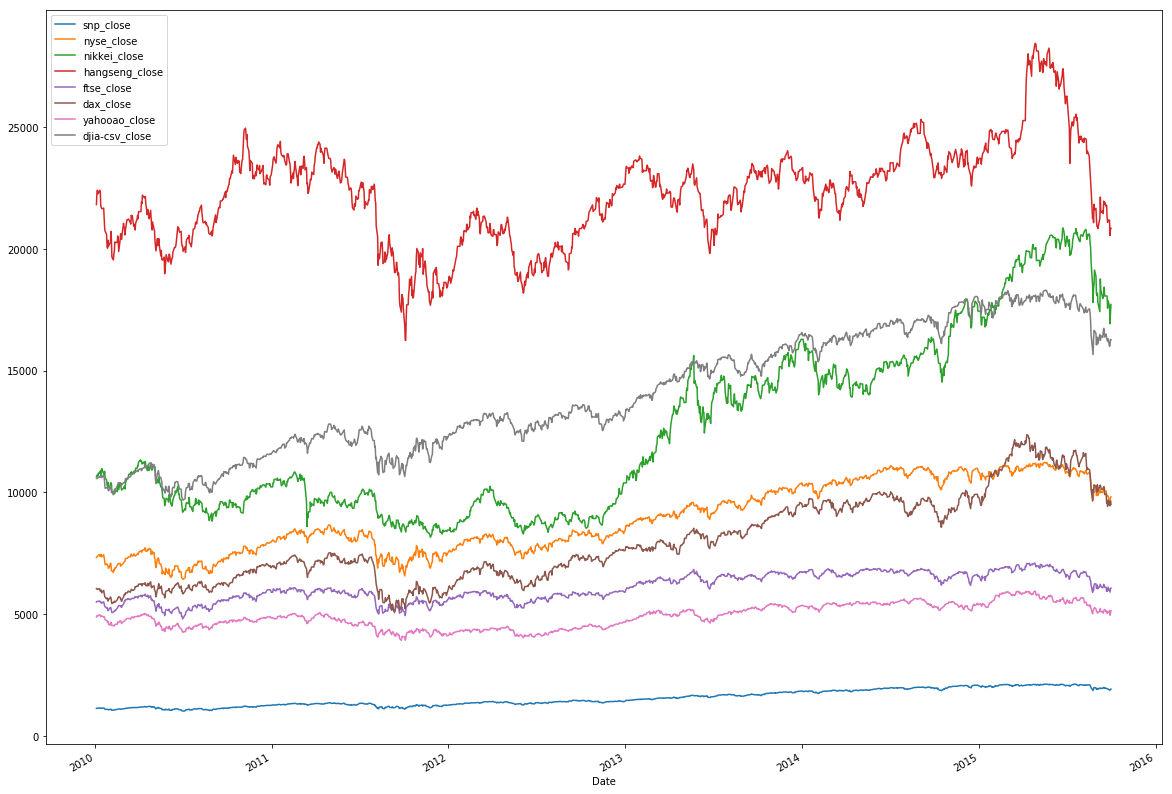

In [27]:
pd.concat([closing_data['{}_close'.format(ticker)] for ticker in tickers], axis=1).plot(figsize=(20, 15))

As expected, the structure isn't uniformly visible for the indices. Divide each value in an individual index by the maximum value for that index., and then replot. The maximum value of all indices will be 1.

In [29]:
for ticker in tickers:
    closing_data['{}_close_scaled'.format(ticker)] = closing_data['{}_close'.format(ticker)]/max(closing_data['{}_close'.format(ticker)])

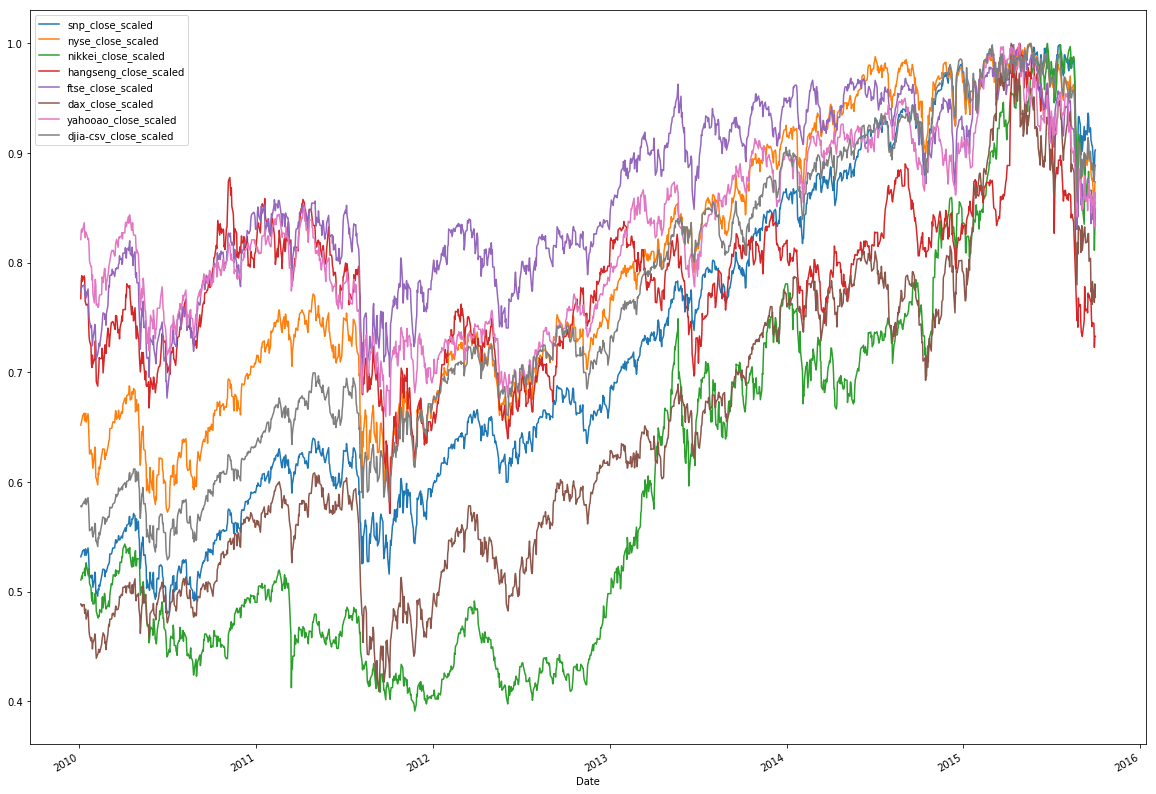

In [30]:
_ = pd.concat([closing_data['{}_close_scaled'.format(ticker)] for ticker in tickers], axis=1).plot(figsize=(20, 15))

You can see that, over the five-year period, these indices are correlated. Notice that sudden drops from economic events happened globally to all indices, and they otherwise exhibited general rises. This is an good start, though not the complete story. Next, plot autocorrelations for each of the indices. The autocorrelations determine correlations between current values of the index and lagged values of the same index. The goal is to determine whether the lagged values are reliable indicators of the current values. If they are, then we've identified a correlation.

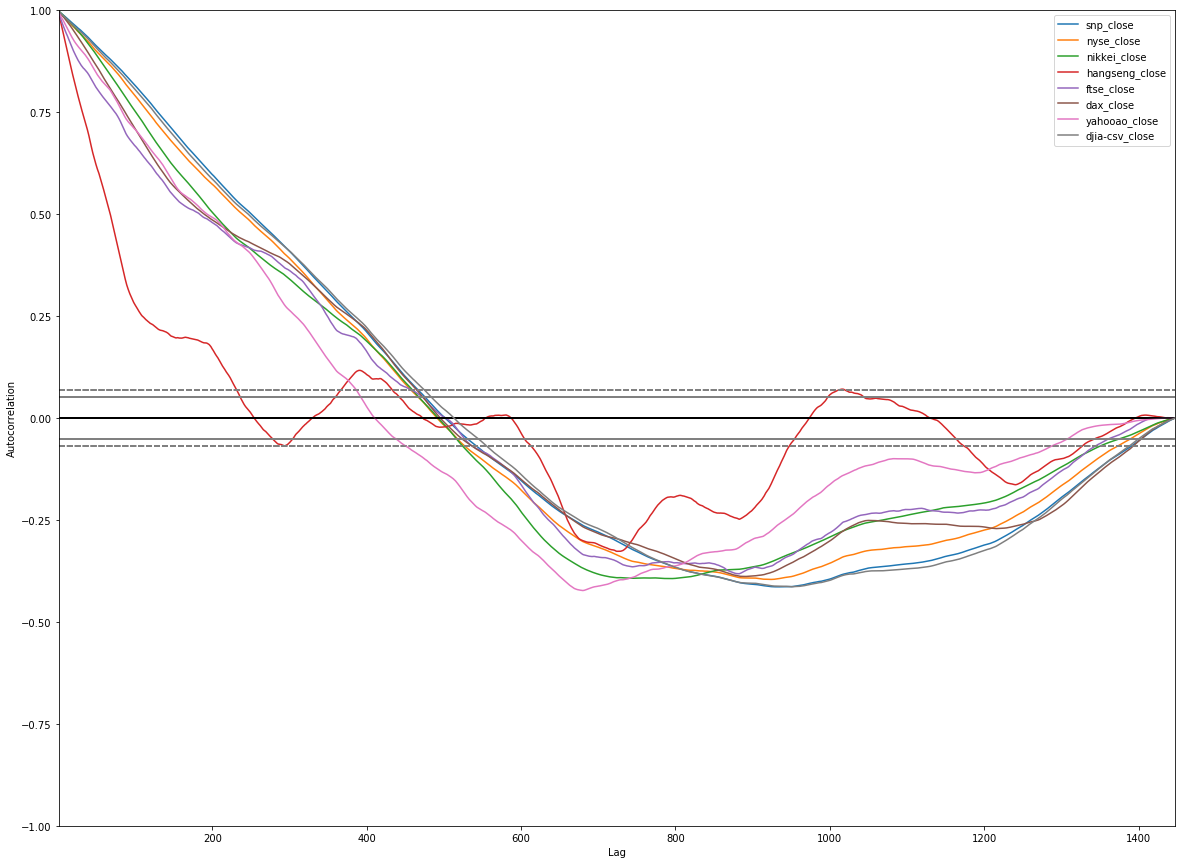

In [31]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(15)

for ticker in tickers:
    _ = autocorrelation_plot(closing_data['{}_close'.format(ticker)], label='{}_close'.format(ticker))

_ = plt.legend(loc='upper right')

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


You should see strong autocorrelations, positive for around 500 lagged days, then going negative. This tells us something we should intuitively know: if an index is rising it tends to carry on rising, and vice-versa. It should be encouraging that what we see here conforms to what we know about financial markets.

Next, look at a scatter matrix, showing everything plotted against everything, to see how indices are correlated with each other.

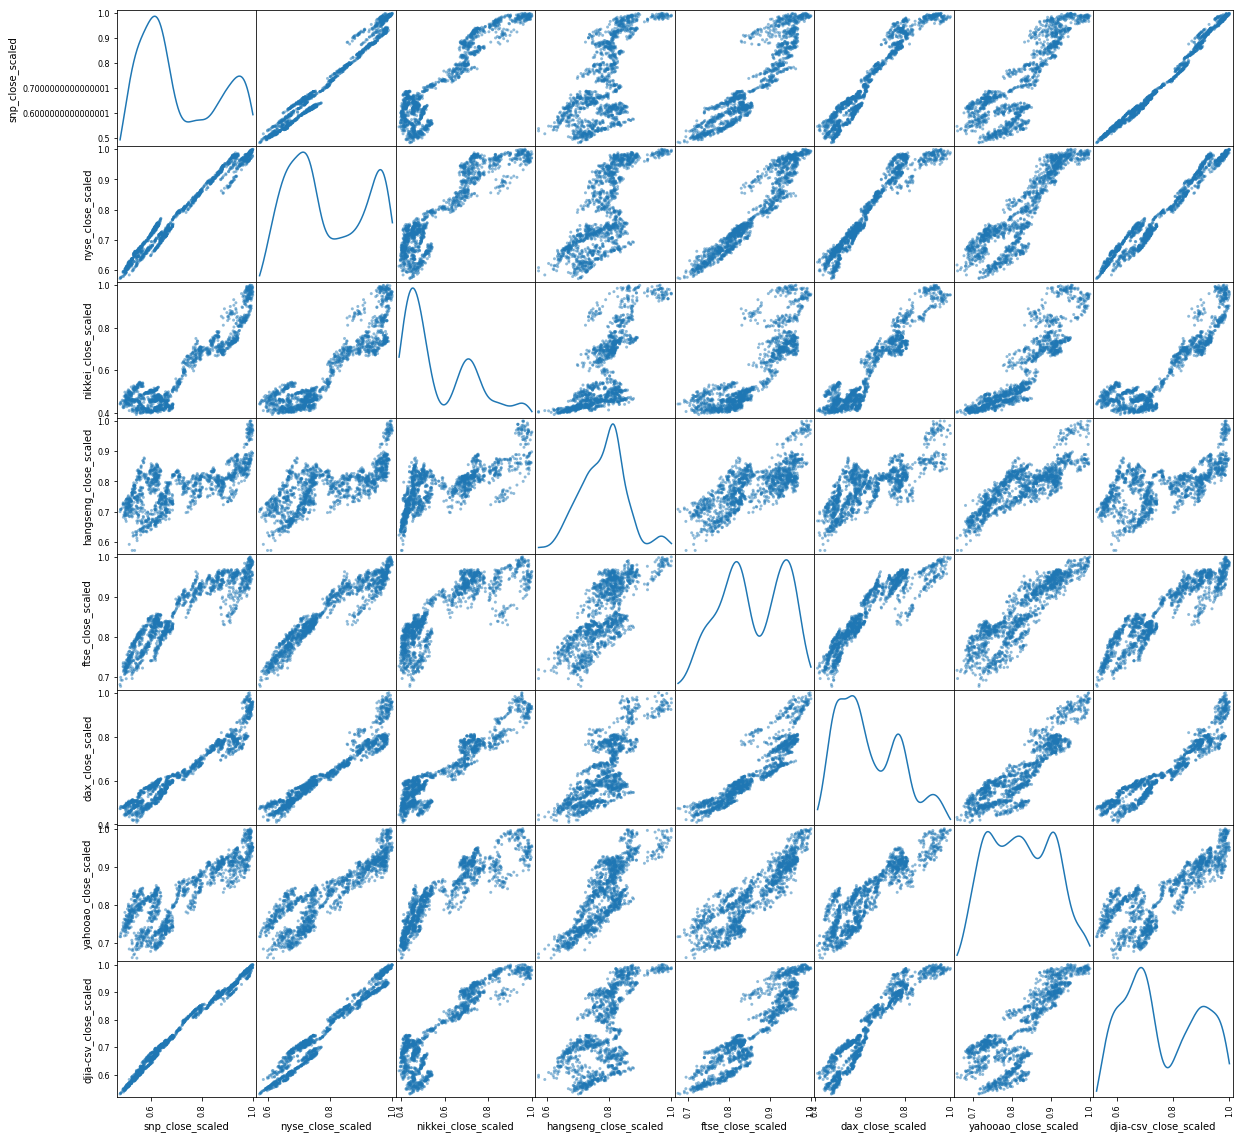

In [32]:
_ = scatter_matrix(pd.concat([closing_data['{}_close_scaled'.format(ticker)] for ticker in tickers],  axis=1), figsize=(20, 20), diagonal='kde')

You can see significant correlations across the board, further evidence that the premise is workable and one market can be influenced by another.

As an aside, this process of gradual, incremental experimentation and progress is the best approach and what you probably do normally. With a little patience, we'll get to some deeper understanding.

The actual value of an index is not that useful for modeling. It can be a useful indicator, but to get to the heart of the matter, we need a time series that is stationary in the mean, thus having no trend in the data. There are various ways of doing that, but they all essentially look at the difference between values, rather than the absolute value. In the case of market data, the usual practice is to work with logged returns, calculated as the natural logarithm of the index today divided by the index yesterday:
```
ln(Vt/Vt-1)
```
There are more reasons why the log return is preferable to the percent return (for example the log is normally distributed and additive), but they don't matter much for this work. What matters is to get to a stationary time series.

Calculate and plot the log returns in a new DataFrame.

In [33]:
log_return_data = pd.DataFrame()

for ticker in tickers:
    log_return_data['{}_log_return'.format(ticker)] = np.log(closing_data['{}_close'.format(ticker)]/closing_data['{}_close'.format(ticker)].shift())
    
log_return_data.describe()

,snp_log_return,nyse_log_return,nikkei_log_return,hangseng_log_return,ftse_log_return,dax_log_return,yahooao_log_return,djia-csv_log_return
count,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000
mean,0.000366,0.000203,0.000352,-0.000032,0.000068,0.000313,0.000035,0.000297
std,0.010066,0.010538,0.013698,0.011779,0.010010,0.013092,0.009170,0.009287
min,-0.068958,-0.073116,-0.111534,-0.060183,-0.047798,-0.064195,-0.042998,-0.057061
25%,-0.004048,-0.004516,-0.006578,-0.005875,-0.004863,-0.005993,-0.004679,-0.003940
50%,0.000628,0.000551,0.000000,0.000000,0.000208,0.000740,0.000407,0.000502
75%,0.005351,0.005520,0.008209,0.006169,0.005463,0.006807,0.005499,0.005018
max,0.046317,0.051173,0.074262,0.055187,0.050323,0.052104,0.034368,0.041533


Looking at the log returns, you should see that the mean, min, max are all similar. You could go further and center the series on zero, scale them, and normalize the standard deviation, but there's no need to do that at this point. Let's move forward with plotting the data, and iterate if necessary.

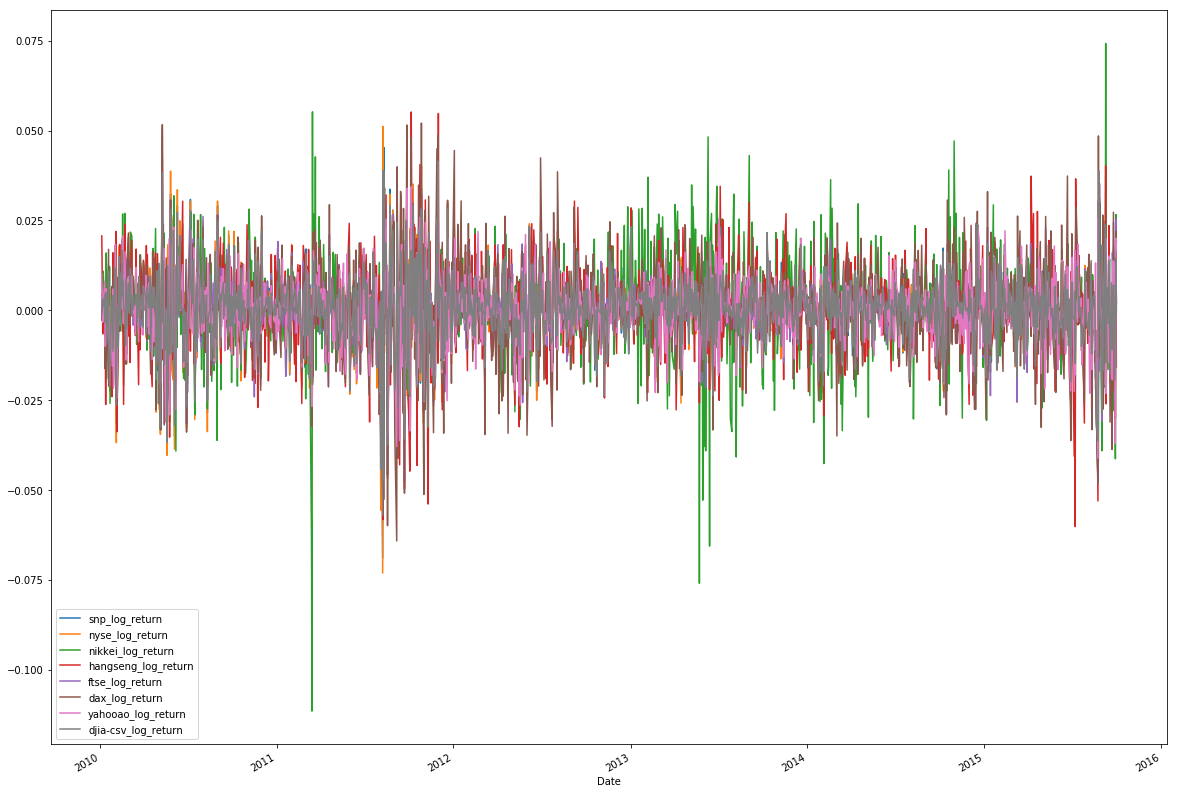

In [34]:
_ = pd.concat([log_return_data['{}_log_return'.format(ticker)] for ticker in tickers], axis=1).plot(figsize=(20, 15))

You can see from the plot that the log returns of our indices are similarly scaled and centered, with no visible trend in the data. It's looking good, so now look at autocorrelations.

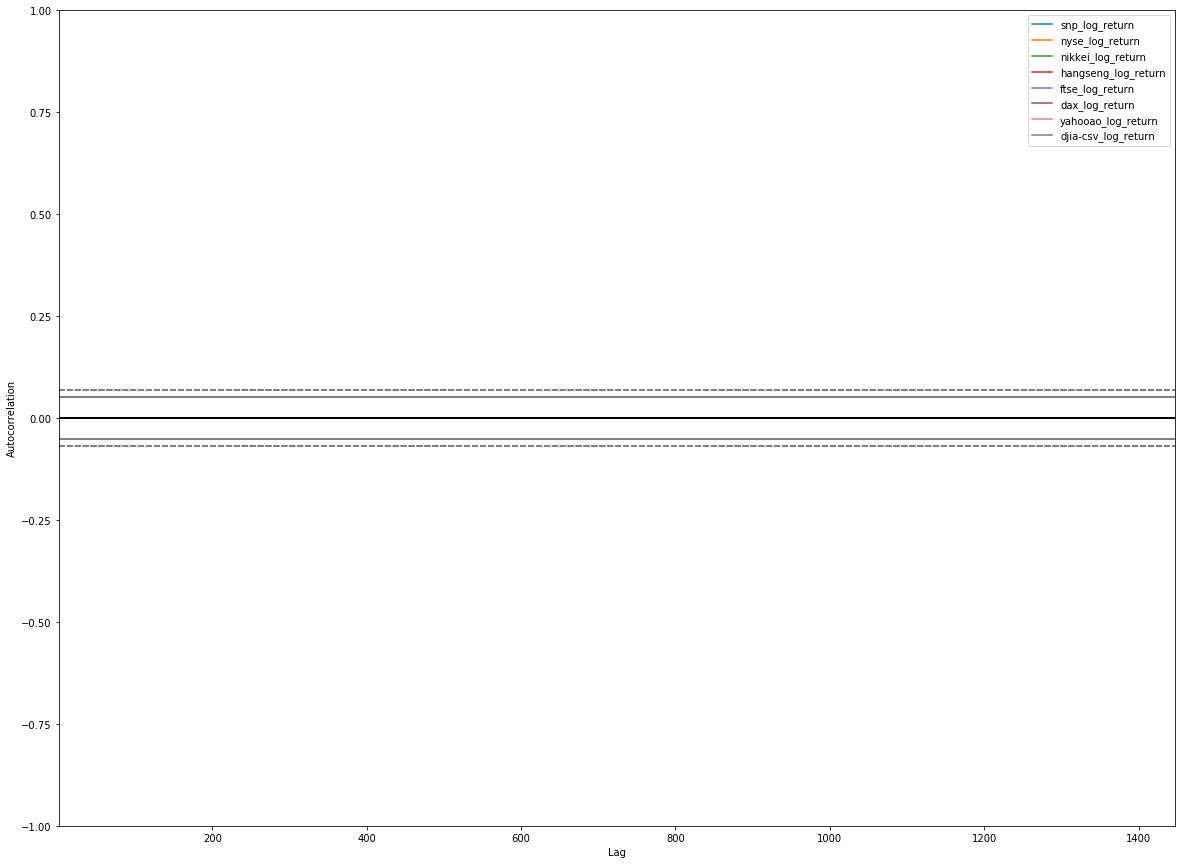

In [35]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(15)

for ticker in tickers:
    _ = autocorrelation_plot(log_return_data['{}_log_return'.format(ticker)], label='{}_log_return'.format(ticker))

_ = plt.legend(loc='upper right')